In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl
import pandas as pd

# import jupyternotify
import pylab as pl
import subprocess
import concurrent.futures
import shutil

# ip = get_ipython()
# ip.register_magics(jupyternotify.JupyterNotifyMagics)


In [2]:

os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')


ERROR: (gcloud.compute.instances.delete) argument INSTANCE_NAMES [INSTANCE_NAMES ...]: Must be specified.
Usage: gcloud compute instances delete INSTANCE_NAMES [INSTANCE_NAMES ...] [optional flags]
  optional flags may be  --delete-disks | --help | --keep-disks | --zone

For detailed information on this command and its flags, run:
  gcloud compute instances delete --help
ERROR: (gcloud.compute.instances.delete) argument INSTANCE_NAMES [INSTANCE_NAMES ...]: Must be specified.
Usage: gcloud compute instances delete INSTANCE_NAMES [INSTANCE_NAMES ...] [optional flags]
  optional flags may be  --delete-disks | --help | --keep-disks | --zone

For detailed information on this command and its flags, run:
  gcloud compute instances delete --help
ERROR: (gcloud.compute.instances.delete) argument INSTANCE_NAMES [INSTANCE_NAMES ...]: Must be specified.
Usage: gcloud compute instances delete INSTANCE_NAMES [INSTANCE_NAMES ...] [optional flags]
  optional flags may be  --delete-disks | --help | --k

512

In [3]:
config_list = ['cre_setup_1_scale_1_node_info']




# config_list2 = ['global_12cls',\
#                 'local_12cls',\
#                'global_3cls',\
#                'global_4cls',\
#                'global_6cls',\
#                'global_8cls',\
#                'global_2cls',\
#                'local_3cls',\
#                'local_4cls',\
#                'local_6cls',\
#                'local_8cls',\
#                'local_2cls']
# config_list2 = ['local_2cls']


config_list = config_list

In [4]:
# config_file = config_list[0]

In [5]:

for cfig in config_list:    
    try:

        os.system('cp node_setup/'+cfig+'.csv node_info.csv')


        df =pd.read_csv('node_info.csv')

        node_info_dict = df.to_dict()

        node_info_dict

        total_count = 0

        for key in node_info_dict['ServerOrClientregion'].keys():
            if node_info_dict['ServerOrClientregion'][key] ==0:
                total_count = total_count + 1

        total_count

        replica_count = 0

        for key in node_info_dict['cluster_id'].keys():
            if node_info_dict['cluster_id'][key] ==0:
                replica_count = replica_count + 1


        replica_count       

        node_info_dict

        n_clusters = int(total_count / replica_count)

        nclients = 0

        for i in node_info_dict['ServerOrClientregion']:
        #     print(node_info_dict['ServerOrClientregion'][i])
            if node_info_dict['ServerOrClientregion'][i] == 1:
                nclients = nclients + 1
        nclients

        clusters_tracked = []
        cluster_regions_tracked = []

        for key in node_info_dict['region']:
            if int(node_info_dict['cluster_id'][key]) not in clusters_tracked and int(node_info_dict['cluster_id'][key]) >=0:
                clusters_tracked.append(int(node_info_dict['cluster_id'][key]))
                cluster_regions_tracked.append(node_info_dict['region'][key].strip().replace('"', '')[1:-1])


        cluster_regions_tracked     

        cluster_regions_tracked, clusters_tracked


        regions = cluster_regions_tracked



        n_regions = len(regions)

        for i,k in enumerate(regions):
            print(i,k)

        for item, idx in enumerate(node_info_dict['region'].keys()):
            print(item, idx, node_info_dict['region'][item])

        lines  = []


        for idx, key in enumerate( node_info_dict['region'].keys()):

            line = 'gcloud compute instances create resdb-'+f"{idx:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+node_info_dict['region'][key].strip()[1:-1]+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'
            lines.append(line)

        with open('launch_cloud_instances.sh', 'w') as f:
            for item in lines:
                f.write(str(item) + '\n')


        len(lines), node_info_dict['region'][key].strip()[1:-1]


        def run_command(command):
            subprocess.call(command, shell=True)

        commands = lines

        # Create a ThreadPoolExecutor or ProcessPoolExecutor, depending on your needs
        with concurrent.futures.ThreadPoolExecutor(max_workers=len(commands)) as executor:
            # Submit each command to the executor for parallel execution
            futures = [executor.submit(run_command, command) for command in commands]

            # Wait for all tasks to complete
            concurrent.futures.wait(futures)

    #     time.sleep(30)

        # os.system('sh launch_cloud_instances.sh')

        for folder in os.listdir('.'):
            if 'config' in folder and folder!='config' and 'zip' not in folder and '.' not in folder:
                shutil.rmtree(folder)


        instance_type = 'e2-small'


        redirect = '>'

        os.system('gcloud compute instances list  --format="value(networkInterfaces[0].networkIP)" '+\
                  redirect+' all_internal_ips')



        os.system('gcloud compute instances list --format="value(networkInterfaces[0].networkIP)" '+\
              redirect+' all_external_ips')

        with open('all_internal_ips') as f:
            ipList = f.read().splitlines()
        ipList = [x for x in ipList if x!='None']

        ipList, len(ipList)

        new_server_only_ips= []
        new_client_only_ips= []



        for i in range(total_count + nclients):
            if node_info_dict['ServerOrClientregion'][i] ==0:
                new_server_only_ips = new_server_only_ips + [ipList[i]]
            else:
                new_client_only_ips = new_client_only_ips + [ipList[i]]



        # new_server_only_ips= []
        # new_client_only_ips= []


        # current_region_total = 0
        # for i in range(n_regions):
        #     print(current_region_total,current_region_total+ clusters_per_region_map[i] *replica_count)
        #     new_server_only_ips = new_server_only_ips + ipList[current_region_total:current_region_total+ clusters_per_region_map[i] *replica_count]

        #     new_client_only_ips = new_client_only_ips + ipList[current_region_total+ clusters_per_region_map[i] *replica_count:
        #                                                       current_region_total+ clusters_per_region_map[i] *(replica_count+1)]


        #     current_region_total = current_region_total + clusters_per_region_map[i] *replica_count +  clusters_per_region_map[i]

        new_server_only_ips, len(new_server_only_ips)

        new_client_only_ips, len(new_client_only_ips) 

        # ipList = new_server_only_ips + new_client_only_ips

        # ipList, len(ipList)

        nclients = 0
        nservers = 0
        count = 0

        clusterIpMap = {}


        for i in node_info_dict['ServerOrClientregion']:
        #     print(node_info_dict['ServerOrClientregion'][i])

            if node_info_dict['ServerOrClientregion'][i] == 0:
                clusterIpMap[nservers] = ipList[count]
                nservers = nservers + 1

            count = count + 1

        nclients = 0
        nservers = 0
        count = 0

        for i in node_info_dict['ServerOrClientregion']:
        #     print(node_info_dict['ServerOrClientregion'][i])

            if node_info_dict['ServerOrClientregion'][i] == 1:
                print('test: ', 7001+nclients, ipList[count])
                clusterIpMap[7001+nclients] = ipList[count]
                nclients = nclients + 1

            count = count + 1

        clusterIpMap

        # clusterIpMap = {}

        # for i in range(len(ipList)):
        #     clusterIpMap[i] = ipList[i]


        # for i in range(nclients):

        #     clusterIpMap[7001+i] = ipList[-(nclients-i)]

        clusterPortMap1 = {}
        clusterPortMap2 = {}

        for i in range(len(ipList) - nclients):

            clusterPortMap1[i] = str(10000)

        for i in range(len(ipList) - nclients):
            clusterPortMap2[i] = str(20000)

        # clusterPortMap1[7003] = '11400'
        # clusterPortMap2[7003] = '11410'



        temp = 11900

        for i in range(nclients):

            clusterPortMap1[7001+i] = str(10000)
            clusterPortMap2[7001+i] = str(20000)

        clusterPortMap1, clusterPortMap2

        os.system('echo 3108 | sudo -S ./gradlew installDist')

        for i in range(total_count):
            os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(i)+' 1024')



        os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7002)+' 1024')
        os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7001)+' 1024')

        os.system('echo 3108 | sudo -S ./gradlew clean')

        for key in clusterPortMap1.keys():
            if key>7002:
        #         print(key)
                print()

                for folder in os.listdir('config/'):
                    if os.path.isdir('config/'+folder) and 'keys' in folder:
                        if os.path.exists('config/'+folder+'/'+'privatekey7001'):
                            shutil.copy('config/'+folder+'/'+'privatekey7001','config/'+folder+'/'+'privatekey'+str(key))
                            shutil.copy('config/'+folder+'/'+'publickey7001','config/'+folder+'/'+'publickey'+str(key))

                print('----------')
                print()

        for i in range(n_clusters):

            if os.path.exists('config'+str(i)):
                shutil.rmtree('config'+str(i))

            os.mkdir('config'+str(i))
            os.mkdir('config'+str(i)+'/keysRSA')
            os.mkdir('config'+str(i)+'/keysSunEC')
            os.mkdir('config'+str(i)+'/keysECDSA')

        #     print('config'+str(i)+'/keysECDSA')


            shutil.copytree('config/workloads/', 'config'+str(i)+'/workloads')
            shutil.copytree('config/keysSSL_TLS/', 'config'+str(i)+'/keysSSL_TLS')
        #     print('config/workloads/', 'config'+str(i)+'/workloads')


            for file in os.listdir('config/keys/'):

                shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysRSA/'+file)
                shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysSunEC/'+file)
                shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysECDSA/'+file)


            shutil.copy('config/system.config', 'config'+str(i)+'/system.config')    
            shutil.copy('config/logback.xml', 'config'+str(i)+'/logback.xml')





        clusterIpMap, clusterPortMap1

        def find_key_by_value(dictionary, value):
            for key, val in dictionary.items():
                if val == value:
                    return key
            # If the value is not found, you might want to handle this case accordingly.
            return None


        node_info_dict

        find_key_by_value(node_info_dict['ServerID'], 4)

        for n_cluster in range(n_clusters):

            with open('config'+str(n_cluster)+'/hosts.config','w') as file:

                for key in clusterIpMap:
                    if key < 7000:
                        file.writelines(str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
                        print('test: ',str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
                for key in clusterIpMap:
                    if key >= 7000:
                        file.writelines(str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')
                        print('test: ', str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')

                file.close()


        # for n_cluster in range(n_clusters):

        #     with open('config'+str(n_cluster)+'/hosts.config','w') as file:

        #         for n_cluster1 in range(n_clusters):

        #             for i_replica in range(replica_count):
        #     #             file.writelines(str(i_replica)+' '+clusterIpMap[n_cluster*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster*replica_count+i_replica]+'\n')
        #                 file.writelines(str(n_cluster1*replica_count+i_replica)+' '+clusterIpMap[n_cluster1*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster1*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster1*replica_count+i_replica]+' '+str(n_cluster1)+'\n')

        #         for iter_ in range(len(ipList) - (n_clusters*replica_count)-nclients):
        #             print((n_clusters*replica_count) + iter_)

        # #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(iter_%n_clusters)+'\n')
        #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(0%n_clusters)+'\n')

        #         for i in range(nclients):
        #             file.writelines(str(7001+i)+' '+clusterIpMap[7001+i]+' '+clusterPortMap1[7001+i]+'\n')


        #         file.close()


        replica_count

        # for n_cluster in range(n_clusters):
        #     with open('config'+str(n_cluster)+'/system.config','r') as file:
        #         data = file.readlines()
        #         f = int(np.ceil((replica_count-1)/3))
        #         print('f is',f )

        #         for n_line in range(len(data)):
        #             if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


        #                 data[n_line] = 'system.servers.num = '+str(replica_count)
        #                 print(data[n_line])

        #             if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
        #                 data[n_line] = 'system.servers.f = '+str(f)
        #                 print(data[n_line])


        #             if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
        #                 data[n_line] = 'system.initial.view = '
        #                 for iter_view in range(replica_count):
        #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
        # #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
        #                     print(data[n_line])

        #                 data[n_line] = data[n_line][:-1]
        #                 print(data[n_line])



        #         file.close()

        #     with open('config'+str(n_cluster)+'/system.config', 'w') as f:
        #         for line in data:
        #             f.write(f"{line}\n")




        for n_cluster in range(n_clusters):
            with open('config'+str(n_cluster)+'/system.config','r') as file:
                data = file.readlines()


                nservers = 0
                server_id_list = []



                for i in node_info_dict['ServerOrClientregion']:
                    if node_info_dict['ServerOrClientregion'][i] == 0 and \
                    node_info_dict['cluster_id'][i]  == n_cluster:
                        nservers = nservers + 1
                        server_id_list.append(node_info_dict['ServerID'][i])

                f = int(np.ceil((nservers-1)/3))
                print('f is',f )


                for n_line in range(len(data)):
                    if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


                        data[n_line] = 'system.servers.num = '+str(nservers)
                        print(data[n_line])

                    if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
                        data[n_line] = 'system.servers.f = '+str(f)
                        print(data[n_line])


                    if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
                        data[n_line] = 'system.initial.view = '
                        for iter_view in server_id_list:
                            data[n_line] = data[n_line] +str(iter_view)+','
        #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
                            print(data[n_line])

                        data[n_line] = data[n_line][:-1]
                        print(data[n_line])



                file.close()

            with open('config'+str(n_cluster)+'/system.config', 'w') as f:
                for line in data:
                    f.write(f"{line}\n")


        for n_cluster in range(n_clusters):
            for i in range(400):

                for ncls in  range(1):


        #             print('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
        #                         'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))



                    shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
                                'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))
                    shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
                                'config'+str(n_cluster)+'/keysRSA/'+'privatekey'+str(1000+(ncls*100)+i))

        #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
        #                     'config'+str(n_cluster)+'/keysRSA/'+'publickey7002')

        #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
        #                     'config'+str(n_cluster)+'/keysRSA/'+'privatekey7002')

        # os.system('git remote set-url origin https://github.com/tmane002/BftSmart_Final.git')

        os.system('git add .; git commit -m "Working with modified ClusterInfo";git push')

        time.sleep(30)

        # regions = [ 'us-west1-b', 'us-west1-b', 'us-west1-b']
        # regions = [ 'us-west1-b']


        instance_type = 'e2-small'

        df =pd.read_csv('node_info.csv')

        node_info_dict = df.to_dict()

        node_info_dict

        f = open('all_external_ips', "r")
        data1 = [line.strip() for line in f.readlines()]

        data1 = [x for x in data1 if x!='None']

        f = open('all_internal_ips', "r")
        data2 = [line.strip() for line in f.readlines()]

        data2 = [x for x in data2 if x!='None']

        data2, len(data2)

        data = []

        skip_instances = 0

        for i in range(skip_instances, len(data1)):
            if data1[i]!='None':
                data.append(data1[i] + '    ' + data2[i])

        data, len(data)

        for index, item in enumerate(data1):
            if 'publicIP' not in node_info_dict.keys():
                node_info_dict['publicIP'] = {}


            node_info_dict['publicIP'][index] = item 


        for index, item in enumerate(data2):
            if 'privateIP' not in node_info_dict.keys():
                node_info_dict['privateIP'] = {}

            node_info_dict['privateIP'][index] = item 



        for index, item in enumerate(data):
            if 'publicAndprivateIP' not in node_info_dict.keys():
                node_info_dict['publicAndprivateIP'] = {}

            node_info_dict['publicAndprivateIP'][index] = item 

        node_info_dict









        # time.sleep(60)

        total_count = 0

        for key in node_info_dict['ServerOrClientregion'].keys():
            if node_info_dict['ServerOrClientregion'][key] ==0:
                total_count = total_count + 1

        total_count





        def getTimeThps(file, flag):

            f = open(file, "r")
            data = f.readlines() 

            times = []
            thputs = []
            for line in data:
                if 'throughput[ops/s]' in line:
                    lineData = (line[13+line.find('max[ops/s])>'):-2])
                    print(lineData)

                    times.append(lineData.split('|')[0])
                    thputs.append(lineData.split('|')[-2])
            if (flag): 
                times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
                thputs.append(0)

            return np.array(times).astype(float), np.array(thputs).astype(float) 

        with open('all_external_ips') as f:
            lines = f.read().splitlines()


        lines = [x for x in lines if x!='None']
        lines, len(lines)

        for ip in lines:
            if ip!='None':
                current = (ip.split('.'))

                print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

        ## Set number of clusters

        nclusters = 0

        for folder in os.listdir('.'):
            if 'config' in folder and folder!='config':
                nclusters = nclusters + 1


        print(nclusters)





        nreplicas = int(total_count/nclusters)
        nclients = nclusters


        nodeIps = []
        clientIps = []

        for i in range(total_count + nclients):
            if node_info_dict['ServerOrClientregion'][i] ==0:
                nodeIps.append(lines[i])
            else:
                clientIps.append(lines[i])


        # nodeIps = lines[:nclusters* nreplicas]


        # no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
        no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]


        experiment = 'bft_mc_'+cfig 

        # clientIps = lines[-(nclusters):]



        # clientIps = lines[-nclients:]



        clientIps, no_cluster_yet_nodes



        node_info_dict

        node_info_dict['region'][0].strip()

        ## Functions

        def setup(i):

            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' commands.sh'+' resdb-'+f"{i:02}"+':/home/tejas/commands.sh'

                print(command)
                os.system(command)

        def initialize(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo sh commands.sh"'


                os.system(command)


        def git_clone(i):
            ip = lines[i]
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'


                os.system(command)

        def git_pull(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "git config --global --add safe.directory /home/tejas/BftSmart_Final; cd BftSmart_Final; sudo git pull"'


                os.system(command)

        def compile_job(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo ./gradlew installDist"'


                os.system(command)



        def clean_job(i):
            ip = node_info_dict['publicIP'][i] 

            rm_command = 'sudo rm config/currentView; '
            for iter_ in range(nclusters):
                rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '


            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'


                os.system(command)


        def clean_all(i):
            ip = node_info_dict['publicIP'][i] 

            rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'



            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; '+rm_command+'"'


                os.system(command)





        #     if ip!='None' and( ip in no_cluster_yet_nodes):

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


        #         os.system(command)        
        # #         print(command)

        def check_node(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "tail -n 1000 nohup.out"'


                os.system(command)
        #         print(command)


        def run_basic_client(i):
            cmd_arg = ''

            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

                current = (ip.split('.'))


                cmd_arg = str(node_info_dict['clientID'][i])



                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'


                os.system(command)


        def kill_java(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo killall java; sudo killall nohup; sudo killall hotstuff-app; sudo killall hotstuff-client;"'


                os.system(command)



        def kill_clients(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None' and ip in clientIps:
                current = (ip.split('.'))
                command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'


                os.system(command)

        def run_server_node_check(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

                current = (ip.split('.'))
                command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


                print(command)



        # for i in range(len(lines)):
        #     run_server_node_check(i)

        def run_basic_client_check(i):
            cmd_arg = ''

            ip = node_info_dict['publicIP'][i] 
            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

                cmd_arg = str(node_info_dict['clientID'][i])


        #         print(i, cmd_arg)

                current = (ip.split('.'))
                command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'


                print(command)



        ## First Time Setup

        lines, len(lines)

        # for i in range(10):
        #     setup(i)


        results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
        print(results)  

        results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
        print(results)  

        # ## GIT Clone/Pull



        # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
        # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
        # # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


        # print(results)  

        # ## Compile Job

        results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
        print(results)  

        # ## CLEAN SERVERS

        # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
        # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

        # print(results)  

        results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))


        def run_server_node(i):
            ip = node_info_dict['publicIP'][i] 
        #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(node_info_dict['ServerID'][i])+' >../nohup.out 2>&1 &"'


                os.system(command)



        # for i in node_info_dict['publicIP']:
        #     run_server_node(i)

        ## RUN SERVERS

        # results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
        # print(results)  

        ### CHECK NODE RESULT

        # check_node(0)

        # ## Run basic client

        # # time.sleep(20)
        # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
        # print(results)  

        # check_node(0)

        # time.sleep(60)

        # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

        ## Main Job

        # os.system('git add .; git commit -m "test";git push')


        # time.sleep(60)

        os.system('git add .; git commit -m "Working with modified ClusterInfo";git push')


        #     %%time


        # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

        results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
        # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

        results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
        # print(results) 





        results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
        # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


        results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
        # print(results)  


        print('XXXXXXXX Started Servers XXXXXXXXXXXX')

        time.sleep(40)

        check_node(7)



        print('XXXXXXXX Started Clients XXXXXXXXXXXX')

        results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))

        time.sleep(180)

        results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        check_node(0)

        if not os.path.exists('../Experiments/'+experiment):
            os.mkdir('../Experiments/'+experiment)

        os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')



        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 


            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(node_info_dict['ServerID'][i])+'.out'

                os.system(command)

#                 break;



        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 



            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
                print('client copying id= ',i)
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
                print(command)
                os.system(command)


        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 


            print(i)
            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
                print('client copying id= ',i)


        node_info_dict

        clientIps





        def getTimesThputs(file):
            f = open(file, "r")
            data = f.readlines() 
            times = []
            thputs = []
            latencies = []
            for line in data:
        #         print(line)
                if not line.startswith('--') and 'current ops/sec; ' in line and 'AverageLatency(us)=' in line and not 'JVM' in line:

        #         print(line)
                    times.append(line.split('sec:')[0].strip())
                    thputs.append(line.split(';')[1].split('current')[0].strip())
                
                
                    read_lat = '0'
                    write_lat = '0'
                    
                    if ('READ AverageLatency' in line):
                        
                        print(line)

                        read_lat = line.split('READ AverageLatency(us)=')[1].split(']')[0].strip()
                        
                        
                    if ('UPDATE AverageLatency' in line):                    
                        
                        write_lat = line.split('UPDATE AverageLatency(us)=')[1].split(']')[0].strip()


                    if (('READ AverageLatency' not in line) and ('UPDATE AverageLatency' not in line)):
                        latencies.append(line.split('=')[1].split(']')[0].strip())
                    else:
                        read_frac = 0
                        write_frac = 0
                        
                        if float(read_lat) > 0:
                            read_frac = 0.85
                            
                        if float(write_frac) > 0:
                            write_frac = 0.15
                        
                        lat = str( (write_frac * float(write_lat) +\
                                    read_frac*float(read_lat))/(write_frac+read_frac)\
                                 )
                        latencies.append(lat)

                    print(line,latencies[-1],thputs[-1],times[-1])

            return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  


        times_thputsDict = {}
        times_latsDict = {}


        for ip in clientIps[:1]:    
            i = clientIps.index(ip)

            times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')

            print(times, thputs)
            for i in range(len(times)):
                times_thputsDict[times[i]] = thputs[i]
                times_latsDict[times[i]] = lats[i]


        for ip in clientIps[1:]:    
            i = clientIps.index(ip)

            times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')


            for i in range(len(times)):

                if times[i] in times_thputsDict.keys():
                    times_thputsDict[times[i]] += thputs[i]

                if times[i] in times_latsDict.keys():
                    times_latsDict[times[i]] += lats[i]


        times_thputsDict



        PIK = '../Experiments/'+experiment+"/pickle.dat"

        data = [times_thputsDict, times_latsDict]

        with open(PIK, "wb") as f:
            pickle.dump(data, f)

        experiment

        # experiment = 'TestRun2_8_clusters_2'
        # PIK = '../Experiments/'+experiment+"/pickle.dat"

        data2 = []
        
        with open(PIK, "rb") as f:
            data2 =  pickle.load(f)


        dict1 = data2[0]
        dict2 = data2[1]



        times1 = np.array(list(dict1.keys()))
        thputs = np.array(list(dict1.values()))

        times2 = np.array(list(dict2.keys()))
        lats = np.array(list(dict2.values()))

        times1


        pl.figure(figsize = (12,8))
        pl.rcParams.update({'font.size': 17})
        pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


        pl.title(r'Throughput')


        pl.xlabel('Time (s)')
        pl.ylabel('Throughput (Txn/s)')
        pl.legend()
        pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
        pl.show()




        pl.figure(figsize = (12,8))
        pl.rcParams.update({'font.size': 17})
        pl.plot(times1[:], lats[:]/ len(clientIps), '-o', label='BfTSmart-MC')


        pl.title(r'Latency')


        pl.xlabel('Time (s)')
        pl.ylabel('Latency (Txn/s)')
        pl.legend()
        pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
        pl.show()

        times1, lats

        lats, np.average(lats[-85:-5])/len(clientIps)

        np.sum(thputs),  np.average(thputs[-85:-5])

        thputs

        np.average(thputs[60:80]), np.average(lats[60:80])/nclusters, np.average(thputs[-35:-5]), np.average(lats[-35:-5])

        # np.average(lats[-50:]), np.average(thputs[-50:]) # (0.0542783668, 166.87759999999997)

        np.sum((thputs[:180]))

        np.sum((thputs[:180]))




        os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')

    except:
        os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')
        continue
    

0 europe-west3-c
1 europe-west3-c
0 0  'europe-west3-c'
1 1  'europe-west3-c'
2 2  'europe-west3-c'
3 3  'europe-west3-c'
4 4  'europe-west3-c'
5 5  'europe-west3-c'
6 6  'europe-west3-c'
7 7  'europe-west3-c'
8 8  'europe-west3-c'
9 9  'europe-west3-c'
10 10  'europe-west3-c'
11 11  'asia-south1-c'
12 12  'asia-south1-c'
13 13  'asia-south1-c'
14 14  'asia-south1-c'
15 15  'asia-south1-c'
16 16  'asia-south1-c'
17 17  'asia-south1-c'


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-14].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-05].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-12].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-10].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-07].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal

NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-14  asia-south1-c  e2-highmem-2               10.160.0.55  35.200.201.116  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-06].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-17].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-10  europe-west3-c  e2-highmem-2               10.156.0.79  34.159.255.150  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-05  europe-west3-c  e2-highmem-2               10.156.0.89  34.141.33.159  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-07  europe-west3-c  e2-highmem-2               10.156.0.92  35.198.127.118  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-06  europe-west3-c  e2-highmem-2               10.156.0.6   35.234.114.215  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-17  asia-south1-c  e2-highmem-2               10.160.0.64  34.100.250.203  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-16].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-11].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-08].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal

NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-12  asia-south1-c  e2-highmem-2               10.160.0.60  34.93.204.143  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-00  europe-west3-c  e2-highmem-2               10.156.0.80  34.141.37.6  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-04  europe-west3-c  e2-highmem-2               10.156.0.69  34.159.155.111  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-03  europe-west3-c  e2-highmem-2               10.156.0.16  35.246.172.190  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-13].


NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-16  asia-south1-c  e2-highmem-2               10.160.0.66  34.93.64.93  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-08  europe-west3-c  e2-highmem-2               10.156.0.90  34.89.150.143  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-09].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-02  europe-west3-c  e2-highmem-2               10.156.0.93  34.159.65.146  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-01  europe-west3-c  e2-highmem-2               10.156.0.86  34.141.9.93  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-15].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-13  asia-south1-c  e2-highmem-2               10.160.0.65  35.200.221.32  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-09  europe-west3-c  e2-highmem-2               10.156.0.88  35.246.158.147  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-11  asia-south1-c  e2-highmem-2               10.160.0.67  34.100.202.203  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-15  asia-south1-c  e2-highmem-2               10.160.0.68  34.93.184.138  RUNNING
test:  7001 10.156.0.88
test:  7002 10.156.0.79
test:  7003 10.160.0.66
test:  7004 10.160.0.64


[sudo] password for tejas: 


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar


Note: /home/tejas/work/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 4s
3 actionable tasks: 3 executed


[sudo] password for tejas: 

> Task :clean

BUILD SUCCESSFUL in 1s
1 actionable task: 1 executed

----------


----------

test:  0 10.156.0.80 10000 20000 0

test:  1 10.156.0.86 10000 20000 0

test:  2 10.156.0.93 10000 20000 0

test:  3 10.156.0.16 10000 20000 0

test:  4 10.156.0.69 10000 20000 0

test:  5 10.156.0.89 10000 20000 0

test:  6 10.156.0.6 10000 20000 0

test:  7 10.156.0.92 10000 20000 1

test:  8 10.156.0.90 10000 20000 1

test:  9 10.160.0.67 10000 20000 1

test:  10 10.160.0.60 10000 20000 1

test:  11 10.160.0.65 10000 20000 1

test:  12 10.160.0.55 10000 20000 1

test:  13 10.160.0.68 10000 20000 1

test:  7001 10.156.0.88 10000

test:  7002 10.156.0.79 10000

test:  7003 10.160.0.66 10000

test:  7004 10.160.0.64 10000

test:  0 10.156.0.80 10000 20000 0

test:  1 10.156.0.86 10000 20000 0

test:  2 10.156.0.93 10000 20000 0

test:  3 10.156.0.16 10000 20000 0

test:  4 10.156.0.69 10000 20000 0

test:  5 10.156.0.89 10000 20000 0

test:  6 10.156.0.6 10000 20000 0

test:  7 10.156.0.92 100

To github.com:tmane002/BftSmart_Final.git
   eaba7268..9c658454  main -> main


ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-80.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-86.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-93.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-16.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-69.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-89.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-6.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-92.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-90.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-88.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-79.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-160-0-67.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-160-0-60.us-west-1.compute.a

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu

Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://euro

Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [488 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2569 kB]
Get:24 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [405 kB]
Get:25 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:26 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2451 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [359 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [55

Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [862

Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1141 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [192 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [273 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [25.8 kB]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7484 B]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/mult

Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2640 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [405 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2451 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [342 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [916 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [192 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.6 kB]
Get:4

Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [359 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [916 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [192 kB]
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1141 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.6 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [273 kB]
Get:28 http://asia-so

Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1141 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [273 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [25.8 kB]
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7484 B]
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubunt


Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b

Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://europe-west3.gce.archive.ub

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Fetched 29.7 MB in 7s (4554 kB/s)
Reading package lists...Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package binutils-common:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Selecting pre

Fetched 29.7 MB in 5s (5493 kB/s)
Reading package lists...Fetched 29.7 MB in 5s (5507 kB/s)
Reading package lists...
Reading state information...
Fetched 29.7 MB in 5s (5496 kB/s)
Reading package lists...Fetched 29.7 MB in 7s (4517 kB/s)
Reading package lists...Fetched 29.7 MB in 5s (5404 kB/s)
Reading package lists...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 li

Reading package lists...
Building dependency tree...
Reading state information...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...

Reading state information...

Fetched 29.7 MB in 7s (4488 kB/s)
Reading package lists...Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...

Reading state information...
Reading package lists...
Building dependency tree...



The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
Suggested packages:

  x11-utils
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 libxrandr2 libxrender1
  libxshmfence1 libxt6 libxtst6 libxv1 libxxf86dga1 libxxf86vm1
  mesa-vulkan-drivers openjdk-11-jre openjdk-11-jre-headless x11-common
  x11-utils
0 upgraded, 77 newly installed, 0 to remove and 68 not upgraded.
0 upgraded, 77 newly installed, 0 to remove and 68 not upgraded.
Reading package lists...1 upgraded, 41 newly installed, 0 to remove and 67 not

Selecting previously unselected package gcc-9.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libg

Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 l

Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.
Reading package lists...The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-syn

Reading package lists...
Building dependency tree...Reading package lists...Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be 

Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]


Building dependency tree...Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubun

Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Get:4 http://a

Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package make.
Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Unpacking make (4.2.1-1.2) ...
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
Ge

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
0 upgraded, 77 newly installed, 0 to remove and 68 not upgraded.
Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Selecting previously unselected package libalgorithm-merge-perl.
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:35 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential a

The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
  libc6
Get:42 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to un

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.7) ...
Setting up li

Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
(Reading database ... 62221 files and directories currently installed.)
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 48.2 MB in 2s (23.9 MB/s)
Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
(Reading database ... 75%
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://

does not have a stable CLI interface. Use with caution in scripts.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Fetched 48.2 MB in 3s (17.2 MB/s)
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.7 [3380 B]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.7) ...
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-169.187 [1125 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2640 kB]
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Get:10 http://asia-south1.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


0 upgraded, 77 newly installed, 0 to remove and 68 not upgraded.
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Need to get 80.2 MB of archives.
Aft

Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: ReadlineSelecting previously unselected package libbinutils:amd64.

Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.7) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Setting up libc6:amd64 (2.31-0ubuntu9.1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Unpacking libctf0:amd64 (2.34-6ubuntu1.7) ...
Get:34 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [

Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Selecting previously unselected package libctf0:amd64.
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.7 [47.9 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.7 [46.6 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.7 [1614 kB]
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack ...

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Selecting previously unselected package libisl22:amd64.
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Selecting previously unselected package libcrypt-dev:amd64.
Fetched 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-169.187 [1125 kB]
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Get:40 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Selecting previously unselected package binutils.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../05-binutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.7) ...
debconf: una

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libctf0:amd64.
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Unpacking libctf0:amd64 (2.34-6ubuntu1.7) ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Selecting previously unselected package libmpc3:amd64.
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Fetched 48.2 MB in 3s (

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libisl22:amd64.
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Fetched 48.2 MB in 2s (29.4 MB/s)
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package libcc1-0:amd64.
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Selecting previously unselected package binutils-common:amd64.
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
(Reading database ... 60%
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package libitm1:amd64.Selecting previously unselected package cpp.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...

Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_

Selecting previously unselected package libcc1-0:amd64.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package binutils-common:amd64.
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) .

Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libcrypt-dev:amd64.
Selecting previously unselected package libquadmath0:amd64.
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package libtsan0:amd64.
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../16-

Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package binutils.
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.7) ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package liblsan0:amd64.
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package linux-libc-dev:amd64.
Selecting previously unselected pac

Selecting previously unselected package gcc-9-base:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package liblsan0:amd64.
Selecting previously unselected package g++-9.
Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package g++-9.
Selecting previously unselected package gcc-9.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libisl22:amd64.
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack 

Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package libalgorithm-merge-perl.
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package gcc.
Selecting previously unselected package gcc-9.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package make.
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking make (4.2.1-1.2) ...
Selecting previously unselected package build-essential.
Selecting previously unselected package g++.
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../

Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libasan5:amd64.
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking build-essential (12.8ubuntu1.1) ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libalgorithm-diff-p

Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libfakeroot:amd64.
Setting up build-essential (12.8ubuntu1.1) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up fakeroot (1.24-1) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package gcc-9.
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
S

Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Unpacking g++ (4:9.3.0-

Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package gcc.
Setting up g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libalgorithm-merge-perl.
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to un

Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.7) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package manpages-dev.
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking manpages-dev (5.05-1) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Setting up binutils (2.34-6ubuntu1.7) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package g++.
Settin

Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Unpacking fakeroot (1.24-1) ...
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Setting up build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libbinutils:amd64 (2.34-6ubuntu1.7) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.7) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package libfakeroot:amd64.
Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Setting up build-essential (12.8ubuntu1.1) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Processing triggers for man-db (2.9.1-1) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04)

Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Setting up binutils (2.34-6ubuntu1.7) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up build-essential (12.8ubuntu1.1) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in au

job.sh: 12: sdk: not found


1 upgraded, 41 newly installed, 0 to remove and 67 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpe

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 43.0 MB in 1s (32.9 MB/s)
Selecting previously unselected package ca-certificates-java.
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://asia-south1.g

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 48.2 MB in 3s (15.9 MB/s)
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package binutils-common:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected packa

Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:vTrus_Root_CA.pemSelecting previously unselected package libtsan0:amd64.

Adding debian:SwissSign_Silver_CA_-_G2.pem
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:USERTrust_RSA_Certification_Authori

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package make.
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Unpacking make (4.2.1-1.2) ...
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libd

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
The following packages will be upgraded:

Reading state information...  curl libcurl4

Processing triggers for man-db (2.9.1-1) ...
Reading package lists...
Building dependency tree...
Reading state information...
Fetched 396 kB in 0s (5170 kB/s)


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Fetched 396 kB in 0s (5095 kB/s)
(Reading database ... 65%Reading database ... 
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
T

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
Fetched 396 kB in 1s (509 kB/s)


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Fetched 396 kB in 0s (4817 kB/s)
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Fetched 396 kB in 0s (4594 kB/s)
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 1s (508 kB/s)
(Reading database ... 85%
Reading state information...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Fetched 396 kB in 0s (4994 kB/s)
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
Preparing to unpack .../libcurl4_7.6

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Reading package lists...
Building dependency tree...The following packages will be upgraded:
  curl libcurl4
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-co

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Fetched 396 kB in 1s (443 kB/s)

Reading state information...
(Reading database ... 75%
Building dependency tree...Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]

Reading state information...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Reading package lists...
Building dependency tree...

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://europe-west3.gce.archive.ub

Selecting previously unselected package libavahi-common-data:amd64.

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMM

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...

Reading state information...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...

Reading state information...
Fetched 396 kB in 0s (4716 kB/s)
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The follo

       `oNs`          -hysosmMMMMydmNmds+-.:ohm           :             sd`        :MMM/      yy
      .hN+           /d:    -MMMmhs/-.`   .MMMh   .ss+-                 `yy`       sMMN`     :N.
     :mN/           `N/     `o/-`         :MMMo   +MMMN-         .`      `ds       mMMh      do
    /NN/            `N+....--:/+oooosooo+:sMMM:   hMMMM:        `my       .m+     -MMM+     :N.
   /NMo              -+ooooo+/:-....`...:+hNMN.  `NMMMd`        .MM/       -m:    oMMN.     hs
  -NMd`                                    :mm   -MMMm- .s/     -MMm.       /m-   mMMd     -N.
 `mMM/                                      .-   /MMh. -dMo     -MMMy        od. .MMMs..---yh
 +MMM.                                           sNo`.sNMM+     :MMMM/        sh`+MMMNmNm+++-
 mMMM-                                           /--ohmMMM+     :MMMMm.       `hyymmmdddo
 MMMMh.                  ````                  `-+yy/`yMMM/     :MMMMMy       -sm:.``..-:-.`
 dMMMMmo-.``````..-:/osyhddddho.           `+shdh+.  

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 


Unpacking liblcms2-2:amd64 (2.9-4) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Fetched 43.0 MB in 1s (48.2 MB/s)
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Fetched 396 kB in 0s (4853 kB/s)

Building dependency tree...Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Selecting previously unselected package ca-certificates-java.
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Prepari

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-common-data:a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libfontconfig1:amd64.
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Get:10 http://asia-south1.gce.archive.ubunt

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ca-certificates-java.
0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package libgraphite2-3:amd64.
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Preparing to unpack .../10-fontconfig-config_2.13.1-2u

job.sh: 12: sdk: not found


Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-headless amd64 11.0.21+9-0ubuntu1~20.04 [38.3 MB]
Selecting previously unselected package libfontconfig1:amd64.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Selecting previously unselected package java-common.
P

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libjpeg-turbo8:amd64.
0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Selecting previously unselected package fontconfig-config.
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Fetched 43.0 MB in 3s (15.5 MB/s)
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://asia-south1.gce.arc

job.sh: 12: sdk: not found


Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-headless amd64 11.0.21+9-0ubuntu1~20.04 [38.3 MB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Se

job.sh: 12: sdk: not found


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacki

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-h

job.sh: 12: sdk: not found


Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsc

job.sh: 12: sdk: not found


Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:    

job.sh: 12: sdk: not found


Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72) ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Selecti

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Fetched 43.0 MB in 1s (44.4 MB/s)
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additi

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Selecting previously unselected package libcups2:amd64.
Fetched 43.0 MB in 3s (15.4 MB/s)
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up default-jre-headless (2:1.11-72) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Unpacking ca-certificates-java (20190405ubuntu1.1) ...Selecting previously unselected package ca-cert

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Selecting previously unselected package liblcms2-2:amd64.
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Selecti

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ca-certificates-java.
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up ant (1.10.7-1) ...
Selecting previously unselected package libpcsclite1:amd64.
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Setting up java-common (0.72) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Selecting previously unselected package fontconfig-config.
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
update-alternatives: using /usr/li

Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Adding debian:COMODO_ECC_Certification_Authority.pem
Unpacking fonts-dejavu-core (2.37-1) ...
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Selecting previously unselected package libharfbuzz0b:amd64.
Adding debian:ISRG_Root_X1.pem
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Adding debian:E-Tugra_Certification_Authority.pem
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Certainly_Root_R1.pem
Setting up ant (1.10.7-1) ...
Setting up ca-certificates-java (20190405ubun

Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Setting up default-jre-headless (2:1.11-72) ...
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding de

Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:HiPKI_Root_CA_-_G1.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Trustwa

Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:CA_Disig_Root_R2.pem0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:AffirmTrust_Commercial.pem
done.
Selecting previously unselected package ant.

Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem

Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Certum_Trusted_Root_CA.pemSetting up ant-optional (1.10.7-1) ...
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Adding debian:NAVER_Global_Root_Certification_Authority.pem

Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:emSign_Root_CA_-_C1.pem
Unpa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up java-common (0.72) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Setting up ant (1.10.7-1) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking j

Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:TWCA_Root_Certification_Authority.pemAdding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem

Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:Certigna.pemAdding debian:E-Tugra_Global_Root_CA_ECC_v3.pem

Adding debian:GlobalSign_Root_R46.pem
Adding debian:Buypass_Class_3_Root_CA.pemAdding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem

Addi

Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pemAdding debian:E-Tugra_Global_Root_CA_ECC_v3.pem

Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:GTS_Root_R2.pemAdding debian:DigiCert_TLS_RSA4096_Root_G5.pem

Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
done.
Setting up ant-optional (1.10.7-1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Updating certificates in /etc/ssl/certs...
Selecting previously

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode

Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Telia_Root_CA_v2.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:SecureTrust_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTr

iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72) ...
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Addin

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem
Selecting previously unselected package ant.
Selecting previously unselected package default-jre-headless.
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:emSign_Root_CA_-_G1.pem
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking ant (1.10.7-1) ...
Adding debian:GlobalSign_Root_CA_-_R6.pem
Unpacking default-jre-headless (2:1.11-72) ...
Adding debian:HiPKI_Root_CA_-_G1.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...
Reading package lists...Selecting previously unselected package ant-optional.
Prepari

Unpacking ant-optional (1.10.7-1) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:SecureSign_RootCA11.pem
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Unpacking default-jre-headless (2:1.11-72) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:AffirmTrust_Premium.pem
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Selecting previously unselected package ant.
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libcups2:amd64 (

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
Adding debian:DigiCert_Global_Root_CA.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:HiPKI_Root_CA_-_G1.pem
update-alternatives: using /usr/lib/jvm/

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:ACCVRAIZ1.pem
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Adding debian:vTrus_Root_CA.pem
update-alternatives: using /usr/lib/jvm/jav

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Setting up ant (1.10.7-1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Reading package lists...
Building dependency tree...Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:Certainly_Root_E1.pem
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Ad

Adding debian:Secure_Global_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockde

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:T-TeleSec_GlobalRoot_Class_3.pemAdding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem

Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:HiPKI_Root_CA_-_G1.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:E-Tugra_Certification_Authority.pemAdding debian:Security_Communication_Root_CA.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem

Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:OISTE_WISeKey_Global_R

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:GlobalSign_Root_R46.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:Telia_Root_CA_v2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove

Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pemUnpacking default-jre-headless (2:1.11-72) ...

Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
done.
Adding debian:Hongkong_Post_Root_CA_3.pem
Setting up ant-optional (1.10.7-1) ...
Adding debian:ACCVRAIZ1.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Selecting previously unselected package ant.
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pemUnpacking ant (1.10.7-1) ..

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:TWCA_Global_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Telia_Root_CA_v2.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:QuoVadis_Root_CA_2.pem

Reading state information...
Adding debian:SecureTrust_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certi

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
done.
Setting up ant-optional (1.10.7-1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Updating certificates in /et

job.sh: 12: sdk: not found


done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...

Reading state information...
Reading package lists...Building dependency tree...
Building dependency tree...
Reading state information...
Reading package lists...
Building dependency tree...iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.

Reading state information...
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Reading package lists...

Reading state information...
Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libc

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
0 upgraded, 0 newly in

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Fetched 43.0 MB in 3s (14.0 MB/s)
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Selecting previously unselected package ca-certificates-java.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpac

Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Telia_Root_CA_v2.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:SecureTrust_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding deb

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
...Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
....10%...Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
...Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.....Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
...20%..Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.............30%............40%.......10%.......50%.............60%............Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
70%..Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..............80%...20%.............90%.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.....

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 23s
3 actionable tasks: 3 executed

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 36s
3 actionable tasks: 3 executed

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

> Task :processResources NO-SOURCE
> Task :classes

BUILD SUCCESSFUL in 37s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 37s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 38s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 38s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 39s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 38s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 40s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 40s
3 actionable tasks: 3 executed
> Task :installDist

> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed
BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 44s
3 actionable tasks: 3 executed
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process fou

[main 092f14a2] Working with modified ClusterInfo
 1 file changed, 10873 insertions(+), 14334 deletions(-)


To github.com:tmane002/BftSmart_Final.git
   9c658454..092f14a2  main -> main
java: no process found
java: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
java: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
java: no process found
nohup: no process found
nohup: no process found
java: no process found
hotstuff-app: no process found
hotstuff-app: no process found
java: no process found
nohup: no process found
hotstuff-client: no proc

Updating 9c658454..092f14a2
Fast-forward
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main


Updating 9c658454..092f14a2
Fast-forward
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)
Updating 9c658454..092f14a2
Fast-forward
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)
Updating 9c658454..092f14a2
Fast-forward
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main


Updating 9c658454..092f14a2
Fast-forward
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main


Updating 9c658454..092f14a2
Fast-forward
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main


Updating 9c658454..092f14a2
Fast-forward
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)
Updating 9c658454..092f14a2
Fast-forward
Updating 9c658454..092f14a2
Fast-forward
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main


Updating 9c658454..092f14a2
Fast-forward
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)
Updating 9c658454..092f14a2
Fast-forward
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)
Updating 9c658454..092f14a2
Fast-forward
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main


Updating 9c658454..092f14a2
Fast-forward
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main


Updating 9c658454..092f14a2
Fast-forward
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main


Updating 9c658454..092f14a2
Fast-forward
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)
Updating 9c658454..092f14a2
Fast-forward


From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main


 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)
Updating 9c658454..092f14a2
Fast-forward


From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   9c658454..092f14a2  main       -> origin/main


 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)
Updating 9c658454..092f14a2
Fast-forward
 cre_exp_gc.ipynb | 25207 +++++++++++++++++++++++------------------------------
 1 file changed, 10873 insertions(+), 14334 deletions(-)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon 

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView'rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
: No such file or directory
rm: cannot remove 'config1/currentView'

XXXXXXXX Started Servers XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config1
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 20000, /10.156.0.92, 10.156.0.92
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:2  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:3  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:4  ## CipherSuite: TLS_ECDHE_ECDSA_W

XXXXXXXX Started Clients XXXXXXXXXXXX


nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process fou

-- Out of context msg with id 1375, type: 1375
-- <-- receiving, msg:bftsmart.consensus.messages.OtherClusterMessage@77778d88 with it being OtherClusterMessage=true
-- received ocmd: bftsmart.consensus.messages.OtherClusterMessage@77778d88
-- 


 PROCESSING OtherClusterMessage by Message Handler with type2
-- Tejas: reached inside deliveryOtherCluster type 2, from_cid_start, from, fromConfig, msg.getSender(), are 1360, 7, config1, 7,  getCurrentViewN: 7
-- DoneMainLoopExec.contains(msg.getOcmd().from_cid_start) for cid: 1360, is : false
-- othermsgs_received_mc for tid: 1360, is temp size, nclusters is 2, 2, temp keyset [0, 1]
-- executing for tid: 1360
-- executeMessages for tid: 1360
-- Getting lastdecision for cid: 1360
[INFO] Processing an ordered request withaRequest.getType() being UPDATE
-- Sending reply to 1021 with sequence number 85 and operation ID 549
-- --> 2: sending TOMMessage from: 0 -> [1021]
-- Ending Exec for cId:1375,  ExecLatency: 318825
-- Received read-only TOMMe

-- Received message  type=ACCEPT, number=1378, epoch=0, from=1
-- I'm at consensus 1378 and my last consensus is 1377
-- Message for consensus 1378 can be processed
-- Processing paxos msg with id 1378
-- Processing consensusMessage from: 1, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ACCEPT from 1 for consensus 1378
-- I have 2 ACCEPTs for cId:1378, Timestamp:0 
-- <-- receiving, msg:type=WRITE, number=1378, epoch=0, from=3 with it being OtherClusterMessage=false
-- ConsensusMessage being processed MessageHandler
-- Delivering ConsensusMessage from: 3, type: 44782, propose, write, accept: 44781, 44782, 44783
-- ------CHECKING LIMITS----------
-- Received message  type=WRITE, number=1378, epoch=0, from=3
-- I'm at consensus 1378 and my last consensus is 1377
-- Message for consensus 1378 can be processed
-- Processing paxos msg with id 1378
-- Processing consensusMessage from: 3, type: 44782, propose, write, accept: 44781, 44782, 44783
-- <-- receiving, msg:type=ACCEPT,

rm: cannot remove 'bft_mc_cre_setup_1_scale_1_node_info.png': No such file or directory


client copying id=  9
gcloud compute scp --zone "europe-west3-c" resdb-09:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_1_scale_1_node_info/nohup_client_0.out
client copying id=  10
gcloud compute scp --zone "europe-west3-c" resdb-10:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_1_scale_1_node_info/nohup_client_2.out
client copying id=  16
gcloud compute scp --zone "asia-south1-c" resdb-16:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_1_scale_1_node_info/nohup_client_1.out
client copying id=  17
gcloud compute scp --zone "asia-south1-c" resdb-17:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_1_scale_1_node_info/nohup_client_3.out
0
1
2
3
4
5
6
7
8
9
client copying id=  9
10
client copying id=  10
11
12
13
14
15
16
client copying id=  16
17
client copying id=  17
 2 sec: 56 operations; 56 current ops/sec; [READ AverageLatency(us)=38291.5] 

 2 sec: 56 operations; 56 current ops/sec; [READ AverageLatency(us)=38291.5] 
 38291.5 56

gcloud compute scp --zone "europe-west3-c" commands.sh resdb-05:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-01:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c" commands.sh resdb-14:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-02:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c" commands.sh resdb-17:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c" commands.sh resdb-12:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c" commands.sh resdb-16:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-03:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c" commands.sh resdb-11:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-04:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-09:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south

Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-05].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-06].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-07].
Deleted 

 2 sec: 56 operations; 56 current ops/sec; [READ AverageLatency(us)=38291.5] 

 2 sec: 56 operations; 56 current ops/sec; [READ AverageLatency(us)=38291.5] 
 38291.5 56 2
 3 sec: 60 operations; 3.99 current ops/sec; [READ AverageLatency(us)=3788.67] [UPDATE AverageLatency(us)=1557848] 

 3 sec: 60 operations; 3.99 current ops/sec; [READ AverageLatency(us)=3788.67] [UPDATE AverageLatency(us)=1557848] 
 236897.56949999998 3.99 3
 4 sec: 159 operations; 98.9 current ops/sec; [READ AverageLatency(us)=6767.54] [UPDATE AverageLatency(us)=1277112.5] 

 4 sec: 159 operations; 98.9 current ops/sec; [READ AverageLatency(us)=6767.54] [UPDATE AverageLatency(us)=1277112.5] 
 197319.28399999999 98.9 4
 5 sec: 174 operations; 15 current ops/sec; [READ AverageLatency(us)=2285.5] [UPDATE AverageLatency(us)=1156891.8] 

 5 sec: 174 operations; 15 current ops/sec; [READ AverageLatency(us)=2285.5] [UPDATE AverageLatency(us)=1156891.8] 
 175476.44499999998 15 5
 6 sec: 182 operations; 7.99 current ops/sec;

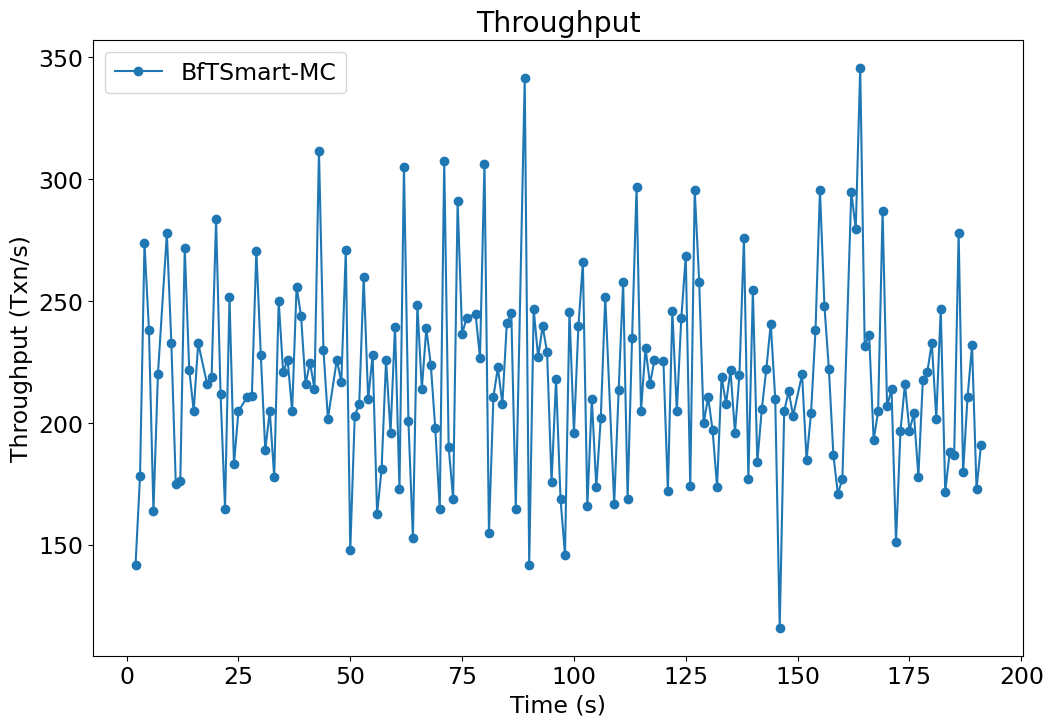

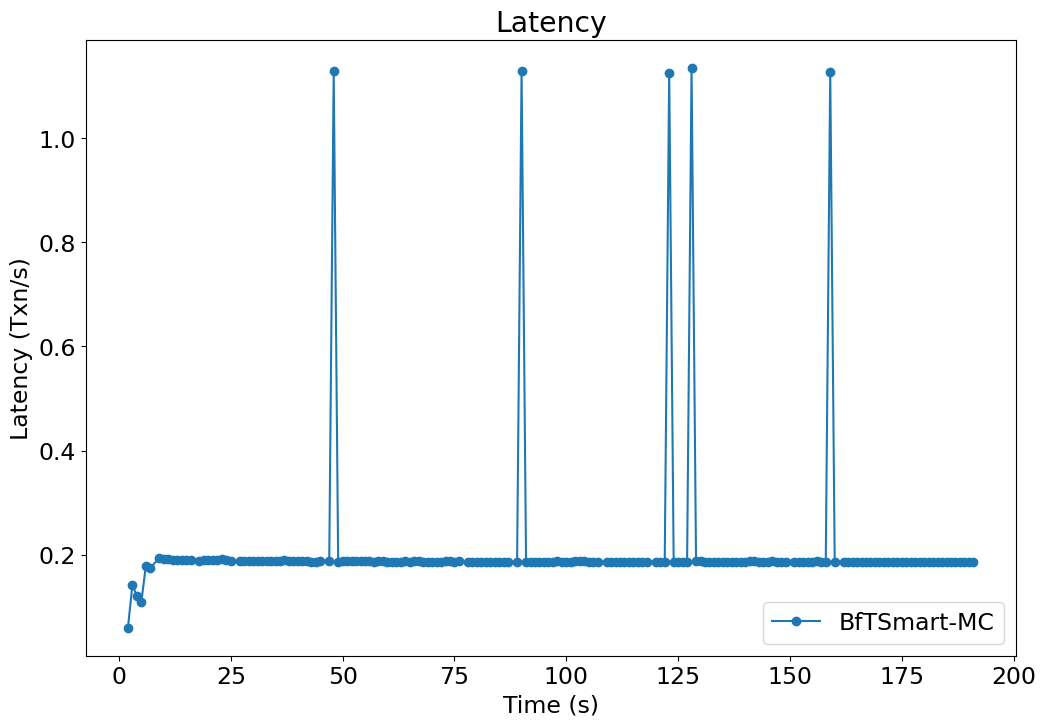

39249.170000000006

In [12]:

        def getTimesThputs(file):
            f = open(file, "r")
            data = f.readlines() 
            times = []
            thputs = []
            latencies = []
            for line in data:
        #         print(line)
                if not line.startswith('--') and 'current ops/sec; ' in line and 'AverageLatency(us)=' in line and not 'JVM' in line:

        #         print(line)
                    times.append(line.split('sec:')[0].strip())
                    thputs.append(line.split(';')[1].split('current')[0].strip())
                
                
                    read_lat = '0'
                    write_lat = '0'
                    
                    if ('READ AverageLatency' in line):
                        
                        print(line)

                        read_lat = line.split('READ AverageLatency(us)=')[1].split(']')[0].strip()
                        
                        
                    if ('UPDATE AverageLatency' in line):                    
                        
                        write_lat = line.split('UPDATE AverageLatency(us)=')[1].split(']')[0].strip()


                    if (('READ AverageLatency' not in line) and ('UPDATE AverageLatency' not in line)):
                        latencies.append(line.split('=')[1].split(']')[0].strip())
                    else:
                        read_frac = 0
                        write_frac = 0
                        
                        if float(read_lat) > 0:
                            read_frac = 0.85
                            
                        if float(write_lat) > 0:
                            write_frac = 0.15
                            
#                         print(line, write_frac, read_frac, float(read_lat), float(write_lat))
                        
                        lat = str( (write_frac * float(write_lat) +\
                                    read_frac*float(read_lat))/(write_frac+read_frac)\
                                 )
                        latencies.append(lat)

                    print(line,latencies[-1],thputs[-1],times[-1])

            return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  

        times_thputsDict = {}
        times_latsDict = {}


        for ip in clientIps[:1]:    
            i = clientIps.index(ip)

            times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')

            print(times, thputs)
            for i in range(len(times)):
                times_thputsDict[times[i]] = thputs[i]
                times_latsDict[times[i]] = lats[i]


        for ip in clientIps[1:]:    
            i = clientIps.index(ip)

            times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')


            for i in range(len(times)):

                if times[i] in times_thputsDict.keys():
                    times_thputsDict[times[i]] += thputs[i]

                if times[i] in times_latsDict.keys():
                    times_latsDict[times[i]] += lats[i]


        times_thputsDict



        PIK = '../Experiments/'+experiment+"/pickle.dat"

        data = [times_thputsDict, times_latsDict]

        with open(PIK, "wb") as f:
            pickle.dump(data, f)

        experiment

        # experiment = 'TestRun2_8_clusters_2'
        # PIK = '../Experiments/'+experiment+"/pickle.dat"

        data2 = []
        
        with open(PIK, "rb") as f:
            data2 =  pickle.load(f)


        dict1 = data2[0]
        dict2 = data2[1]



        times1 = np.array(list(dict1.keys()))
        thputs = np.array(list(dict1.values()))

        times2 = np.array(list(dict2.keys()))
        lats = np.array(list(dict2.values()))

        times1


        pl.figure(figsize = (12,8))
        pl.rcParams.update({'font.size': 17})
        pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


        pl.title(r'Throughput')


        pl.xlabel('Time (s)')
        pl.ylabel('Throughput (Txn/s)')
        pl.legend()
        pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
        pl.show()




        pl.figure(figsize = (12,8))
        pl.rcParams.update({'font.size': 17})
        pl.plot(times1[:], lats[:]/ len(clientIps), '-o', label='BfTSmart-MC')


        pl.title(r'Latency')


        pl.xlabel('Time (s)')
        pl.ylabel('Latency (Txn/s)')
        pl.legend()
        pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
        pl.show()

        times1, lats

        lats, np.average(lats[-85:-5])/len(clientIps)

        np.sum(thputs),  np.average(thputs[-85:-5])

        thputs

        np.average(thputs[60:80]), np.average(lats[60:80])/nclusters, np.average(thputs[-35:-5]), np.average(lats[-35:-5])

        # np.average(lats[-50:]), np.average(thputs[-50:]) # (0.0542783668, 166.87759999999997)

        np.sum((thputs[:180]))

        np.sum((thputs[:180]))



In [7]:
np.average(lats)/nclusters

NameError: name 'lats' is not defined